### Video Understanding with Qwen3-VL

In this notebook, we delve into the capabilities of the **Qwen3-VL** model for video understanding tasks. Our objective is to showcase how this advanced model can be applied to various video analysis scenarios.


#### \[Setup\]

We start by loading the pre-trained `Qwen3-VL` model.

In [1]:
import logging

# configure logging here
# sets the third party's logger to do WARNING or greater
# replace 'foo' with whatever the top-level package name your
# third party package uses
logging.getLogger("qwen_vl_utils").setLevel(logging.DEBUG)
# set any other loggers to use INFO or greater,
# unless otherwise configured explicitly
logging.basicConfig(level=logging.INFO, format="%(process)d %(message)s")

In [2]:
import torch

major_version, minor_version = torch.cuda.get_device_capability()
if major_version >= 8:
    print("GPU is compatible with FlashAttention")
    attn_implementation = "flash_attention_2"
else:
    print("GPU is not compatible with FlashAttention")
    attn_implementation = None

GPU is compatible with FlashAttention


In [3]:
import warnings

from qwen_vl_utils import process_vision_info
from transformers import AutoModelForImageTextToText, AutoProcessor

warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")
import os

# import dashscope
# dashscope.base_http_api_url = 'https://dashscope-intl.aliyuncs.com/compatible-mode/v1'
# os.environ['DASHSCOPE_API_KEY'] = 'sk-***' # Your DashScope API Key
# os.environ['OPENAI_BASE_HTTP_API_URL'] = 'https://dashscope-intl.aliyuncs.com/compatible-mode/v1'
# DASH_MODEL_ID = '***' # Your model-ID for API

model_path = "Qwen/Qwen3-VL-2B-Instruct"  #  The following output example is from a tiny test model
processor = AutoProcessor.from_pretrained(model_path)

model, output_loading_info = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype="bfloat16",
    device_map="auto",
    output_loading_info=True,
    cache_dir=".",
    attn_implementation=attn_implementation,
)
print("output_loading_info", output_loading_info)

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/4.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

output_loading_info {'missing_keys': [], 'unexpected_keys': [], 'mismatched_keys': [], 'error_msgs': []}


In [ ]:
# from datasets import load_dataset
# import pandas as pd

# # Load the datasets
# print("Loading datasets...")

# # Note: We separate segment labels and split definitions, but hugginface datasets always expects a split.
# # Thats why all labels are in the train split when loaded, but we create the actual splits afterwards.
# labels = load_dataset("simplexsigil2/omnifall", "labels")["train"]

# cv_split = load_dataset("simplexsigil2/omnifall", "cv")
# cs_split = load_dataset("simplexsigil2/omnifall", "cs")

# # There are many more splits, relevant for the paper:
# # - cv-staged -> Only lab datasets
# # - cs-staged -> Only lab datasets
# # - cv-staged-wild -> Lab datasets for train and val, only OOPS-Fall in test set
# # - cs-staged-wild -> Lab datasets for train and val, only OOPS-Fall in test set

# # Convert to pandas DataFrames
# labels_df = pd.DataFrame(labels)
# print(f"Labels dataframe shape: {labels_df.shape}")

# # Process each split type (CV and CS)
# for split_name, split_data in [("CV", cv_split), ("CS", cs_split)]:
#     print(f"\n{split_name} Split Processing:")

#     # Process each split (train, validation, test)
#     for subset_name, subset in split_data.items():
#         # Convert to DataFrame
#         subset_df = pd.DataFrame(subset)

#         # Join with labels on 'path'
#         merged_df = pd.merge(subset_df, labels_df, on="path", how="left")

#         # Print statistics
#         print(f"  {subset_name} split: {len(subset_df)} videos, {merged_df.dropna().shape[0]} labelled segments")

#         # Print examples
#         if not merged_df.empty:
#             print(f"\n  {subset_name.upper()} EXAMPLES:")
#             random_samples = merged_df.sample(min(3, len(merged_df)))
#             for i, (_, row) in enumerate(random_samples.iterrows()):
#                 print(f"  Example {i+1}:")
#                 print(f"    Path: {row['path']}")
#                 print(f"    Start: {row['start']}")
#                 print(f"    End: {row['end']}")
#                 print(f"    Label: {row['label']}")
#                 print(f"    Subject: {row['subject']}")
#                 print(f"    Dataset: {row['dataset']}")
#                 print(f"    Camera: {row['cam']}")
#                 print()


: 

Load video frames and timestamps

Inference function

In [4]:
import time


def inference(
    video,
    prompt,
    max_new_tokens=2048,
    total_pixels=20480 * 32 * 32,
    min_pixels=64 * 32 * 32,
    max_pixels=256 * 32 * 32,
    max_frames=2048,
    sample_fps=2,
    target_fps=2,
    return_inputs=False,
):
    """
    Perform multimodal inference on input video and text prompt to generate model response.

    Args:
        video (str or list/tuple): Video input, supports two formats:
            - str: Path or URL to a video file. The function will automatically read and sample frames.
            - list/tuple: Pre-sampled list of video frames (PIL.Image or url).
              In this case, `sample_fps` indicates the frame rate at which these frames were sampled from the original video.
        prompt (str): User text prompt to guide the model's generation.
        max_new_tokens (int, optional): Maximum number of tokens to generate. Default is 2048.
        total_pixels (int, optional): Maximum total pixels for video frame resizing (upper bound). Default is 20480*32*32.
        min_pixels (int, optional): Minimum total pixels for video frame resizing (lower bound). Default is 16*32*32.
        sample_fps (int, optional): ONLY effective when `video` is a list/tuple of frames!
            Specifies the original sampling frame rate (FPS) from which the frame list was extracted.
            Used for temporal alignment or normalization in the model. Default is 2.
        target_fps (int, optional): only effective when 'video' is a str
            Specifies the sampling rate for the model. Default is 2.
            `max_frames` can be used to limit the number of frames to override this setting.


    Returns
    -------
        str: Generated text response from the model.

    Notes
    -----
        - When `video` is a string (path/URL), `sample_fps` is ignored and will be overridden by the video reader backend.
        - When `video` is a frame list, `sample_fps` informs the model of the original sampling rate to help understand temporal density.
    """
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "video": video,
                    "total_pixels": total_pixels,
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    "max_frames": max_frames,
                    "fps": target_fps,
                    "sample_fps": sample_fps,
                },
                {"type": "text", "text": prompt},
            ],
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    start_time_process_vision = time.perf_counter()
    image_inputs, video_inputs, video_kwargs = process_vision_info(
        [messages], return_video_kwargs=True, image_patch_size=16, return_video_metadata=True
    )
    end_time_process_vision = time.perf_counter()
    print(
        f"Time taken for process_vision_info: {end_time_process_vision - start_time_process_vision:.2f} seconds"
    )

    if video_inputs is not None:
        video_inputs, video_metadatas = zip(*video_inputs)
        video_inputs, video_metadatas = list(video_inputs), list(video_metadatas)
        print(f"Video input shape: {video_inputs[0].shape}")
    else:
        video_metadatas = None
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        video_metadata=video_metadatas,
        **video_kwargs,
        do_resize=False,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    start_time_generate = time.perf_counter()
    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    end_time_generate = time.perf_counter()
    print(f"Time taken for model.generate: {end_time_generate - start_time_generate:.2f} seconds")

    generated_ids = [
        output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return (output_text[0], inputs) if return_inputs else output_text[0]

####  \[Usage\]

Once the model is loaded (or the API is ready), you can provide video inputs in **two formats**:

1. **Video URL (`video_url`)** — A file path or publicly accessible HTTP(S) URL pointing to a video file (e.g., MP4, AVI).  
   ✅ Best for quick prototyping or when you want the model/API to handle video decoding internally.
2. **Frame List (`frame_list`)** — A list of PIL Image objects or file paths representing sampled frames from a video.  
   ✅ Best for fine-grained control, preprocessing, or when you’ve already decoded the video.


In [5]:
import hashlib
import math

import numpy as np
import requests
from decord import VideoReader, cpu
from IPython.display import Markdown, display
from PIL import Image


def download_video(url, dest_path):
    response = requests.get(url, stream=True)
    with open(dest_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"Video downloaded to {dest_path}")


def get_video_frames(video_path, num_frames=128, cache_dir=".cache"):
    os.makedirs(cache_dir, exist_ok=True)

    video_hash = hashlib.md5(video_path.encode("utf-8")).hexdigest()
    if video_path.startswith("http://") or video_path.startswith("https://"):
        video_file_path = os.path.join(cache_dir, f"{video_hash}.mp4")
        if not os.path.exists(video_file_path):
            download_video(video_path, video_file_path)
    else:
        video_file_path = video_path

    frames_cache_file = os.path.join(cache_dir, f"{video_hash}_{num_frames}_frames.npy")
    timestamps_cache_file = os.path.join(cache_dir, f"{video_hash}_{num_frames}_timestamps.npy")

    if os.path.exists(frames_cache_file) and os.path.exists(timestamps_cache_file):
        frames = np.load(frames_cache_file)
        timestamps = np.load(timestamps_cache_file)
        return video_file_path, frames, timestamps

    vr = VideoReader(video_file_path, ctx=cpu(0))
    total_frames = len(vr)

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    frames = vr.get_batch(indices).asnumpy()
    timestamps = np.array([vr.get_frame_timestamp(idx) for idx in indices])

    np.save(frames_cache_file, frames)
    np.save(timestamps_cache_file, timestamps)

    return video_file_path, frames, timestamps


def create_image_grid(images, num_columns=8):
    pil_images = [Image.fromarray(image) for image in images]
    num_rows = math.ceil(len(images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new("RGB", (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image

In [6]:
def load_video_as_pil(
    video_path: str,
    sample_fps: float,
    size: tuple[int, int] | None = None,  # (height, width)
) -> tuple[list[Image.Image], list[float]]:
    """Load a video and downsample to `sample_fps`, returning PIL images and timestamps."""
    if sample_fps <= 0:
        raise ValueError("sample_fps must be positive.")

    with av.open(video_path) as container:
        stream = container.streams.video[0]
        stream.thread_type = "AUTO"
        frame_interval = 1.0 / sample_fps
        next_ts = 0.0

        frames: list[Image.Image] = []
        timestamps: list[float] = []

        for frame in container.decode(stream):
            if frame.pts is None or stream.time_base is None:
                continue
            ts = frame.pts * float(stream.time_base)
            if ts + 1e-9 < next_ts:
                continue
            pil_img = frame.to_image().convert("RGB")
            if size is not None:
                # `size` is (height, width) per caller request; PIL expects (width, height)
                pil_img = pil_img.resize((size[1], size[0]), resample=Image.BICUBIC)
            frames.append(pil_img)
            timestamps.append(ts)

            while next_ts <= ts:
                next_ts += frame_interval

    return frames, timestamps

In [7]:
import av
from PIL import Image


def load_video_in_chunks(
    path: str,
    chunk_size: int = 16,
    overlap: int = 4,
    target_fps: float | None = None,
    as_pil: bool = False,
) -> list[list[np.ndarray | Image.Image]]:
    """
    Efficiently loads a video into overlapping chunks with optional FPS downsampling.

    Args:
        path: Path to the video file.
        chunk_size: Number of frames per chunk.
        overlap: Number of overlapping frames between consecutive chunks.
        target_fps: Target FPS to downsample the video. If None, keeps original FPS.
        as_pil: If True, returns frames as PIL.Image instead of np.ndarray.

    Returns
    -------
        List of clips (each clip is a list of frames as np.ndarray or PIL.Image).
    """
    container = av.open(path)
    stream = container.streams.video[0]

    # Determine downsampling ratio
    orig_fps = float(stream.average_rate) if stream.average_rate is not None else 30.0
    frame_skip = max(int(round(orig_fps / target_fps)), 1) if target_fps else 1

    frames = []
    frame_idx = 0

    for packet in container.demux(stream):
        for frame in packet.decode():
            if frame_idx % frame_skip == 0:
                img = frame.to_ndarray(format="rgb24")
                if as_pil:
                    img = Image.fromarray(img)
                frames.append(img)
            frame_idx += 1

    container.close()

    # Build overlapping chunks
    clips = []
    step = chunk_size - overlap
    for i in range(0, len(frames), step):
        clip = frames[i : i + chunk_size]
        if len(clip) < chunk_size:
            break
        clips.append(clip)

    return clips

In [8]:
sample_fps = 2

In [11]:
path = "../../colab_repro/data/WinterFailsJanuary2017_FailArmy0.mp4"

In [12]:
frames, timestamps = load_video_as_pil(path, sample_fps=sample_fps, size=None)

In [13]:
timestamps[-1]

12.512512512512513

In [14]:
import gc

gc.collect()

586

In [15]:
len(frames)

26

10.01001001001001


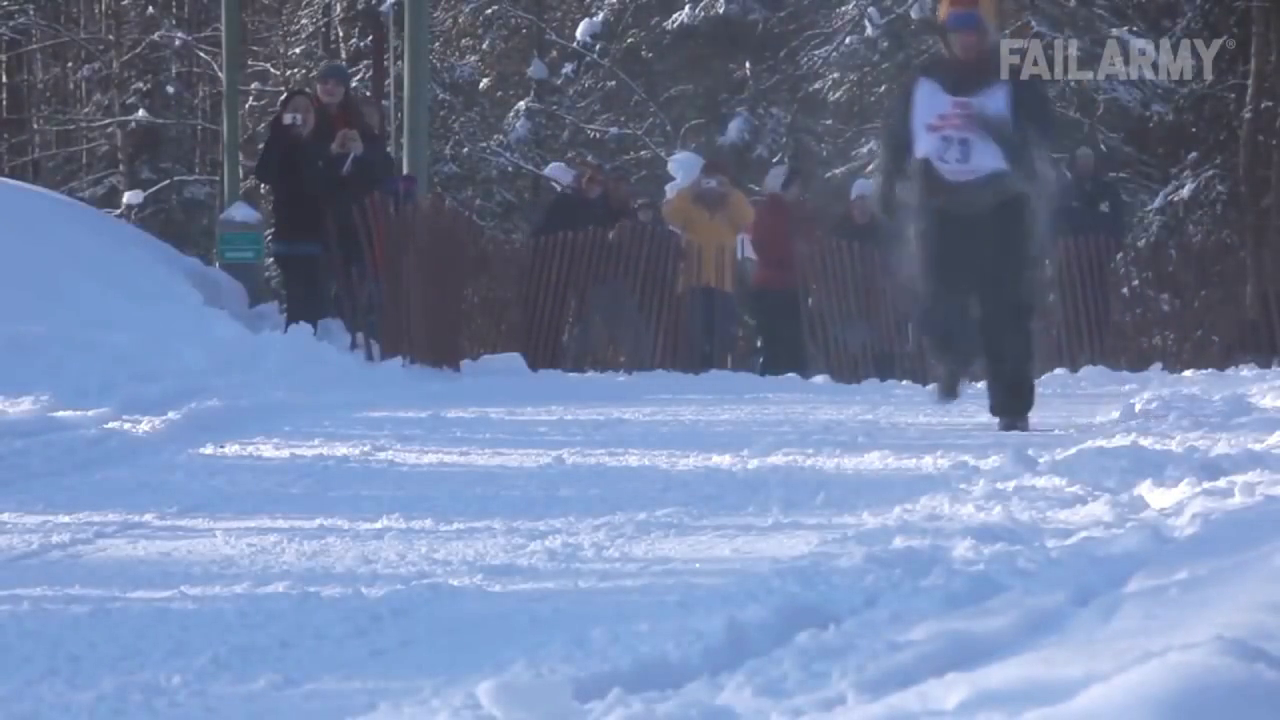

In [16]:
idx = 20
print(timestamps[idx])
frames[idx]

In [17]:
%%time
result, inputs = inference(
    path,
    "Briefly describe this video, focusing on the (infrequent) actions a person does, e.g. falling down or examining something",
    max_pixels=500 * 32 * 32,
    target_fps=2,
    return_inputs=True,
)

qwen-vl-utils using decord to read video.
23025 decord:  video_path='../../colab_repro/data/WinterFailsJanuary2017_FailArmy0.mp4', total_frames=377, video_fps=29.97, time=0.564s


Time taken for process_vision_info: 0.77 seconds
Video input shape: torch.Size([24, 3, 512, 928])
Time taken for model.generate: 83.42 seconds
CPU times: user 1min 27s, sys: 2.86 s, total: 1min 30s
Wall time: 1min 24s


In [20]:
result

'A dog sled team races down a snowy path, with a musher in a yellow jacket and a white bib with the number 23 on his back. The team speeds up and the sled flips over, sending the musher tumbling to the ground. He gets up and runs away from the sled, but the sled still moves forward and the musher is left behind.'

### 1. Using Video URL - Local Inference

In [ ]:
from typing import Annotated

from json_repair import repair_json
from pydantic import BaseModel, Field, ValidationInfo, field_validator, model_validator


class ActionSegment(BaseModel):
    label: Annotated[int, Field(ge=0, le=15)]
    description: str
    start_time: float
    end_time: float

    @field_validator("end_time", mode="after")
    @classmethod
    def end_time_gt_start_time(cls, value: float, info: ValidationInfo):
        if value <= info.data["start_time"]:
            raise ValueError("end_time must be greater than start_time")
        return value


class ActionDetection(BaseModel):
    segments: list[ActionSegment]

    @model_validator(mode="after")
    def check_sorted_and_non_overlapping(self):
        segs = sorted(self.segments, key=lambda s: s.start_time)
        for i in range(len(segs) - 1):
            if segs[i].end_time > segs[i + 1].start_time:
                raise ValueError(
                    f"Segments overlap between index {i} and {i + 1}: "
                    f"{segs[i].end_time} > {segs[i + 1].start_time}"
                )
        self.segments = segs  # assign sorted version
        return self

In [ ]:
prompt = """
You are an expert in human activity recognition. Given a short video, segment it into temporally into continuous intervals, labeling each interval with one of the activity classes.

TASK:
Perform full temporal segmentation of the video into labeled segments. Each segment should have:
- "label": the activity label ID (0 to 9, see below),
- "start_time": when the activity starts (in seconds),
- "end_time": when it ends (in seconds),
- "description": short description of what happens in this segment

ACTIVITY LABELS:
0|walk - Move around, including jogging and running and "drunk walking", but only if it is not part of some special exercise like pulling your knees up. Not when pushing a large object like a chair, but included carrying something small like an apple.
1|fall - The act of falling (from any previous state). Includes falling on a bed, if the process is not a controlled lying down with arms as support.
2|fallen - Being on the ground or a mattress after a fall.
3|sit_down - Sitting down on bed or chair or ground.
4|sitting - Sitting on bed or chair or ground.
5|lie_down - Lying down intentionally (in contrast to a fall) on ground or bed.
6|lying - Being in a lying position (in bed or on the ground) after intentionally getting into that position.
7|stand_up - Standing up from a fallen state, from lying or sitting. Includes getting from lying position into sitting position.
8|standing - Standing around without walking.
9|other - Any other activity, including e.g. walking while pushing an object like a chair.p

DEFINITIONS:
- Transient actions (e.g., sit_down, fall, lie_down, stand_up) mark short events.
- Static states (e.g., sitting, lying, standing, fallen) indicate sustained postures.
- “fall” means an unintentional loss of balance leading to a person ending up on the ground.
- “fallen” refers to the state after a fall when the person remains on the ground.
- “other” should be used for actions not fitting any defined class.

Focus on the activity labels given. If a scene changes slightly, but the label is the same, merge segments so that no segment has the same label as the previous one.

OUTPUT JSON FORMAT: (for example)
{
    segments: [
    {
        "label": 0-9,
        "start_time": float,
        "end_time": float,
        "description": "some text"
    },
    ...
    ]
}
"""

In [ ]:
response = inference(path, prompt, sample_fps=sample_fps, target_fps=10, max_pixels=200 * 500)
display(Markdown(response))
repaired = repair_json(response)

INFO:qwen_vl_utils.vision_process:decord:  video_path='/content/drive/MyDrive/oops_fall/falls/BeeKeeperBusiness-FailsoftheWeekNovember2018_FailArmy18.mp4', total_frames=264, video_fps=29.97, time=1.455s


Time taken for process_vision_info: 3.52 seconds
Video input shape: torch.Size([88, 3, 224, 416])
Time taken for model.generate: 184.85 seconds


```json
{
    "segments": [
        {
            "label": 0,
            "start_time": 0.0,
            "end_time": 0.9,
            "description": "A woman is standing by the water's edge, holding a pole and looking at the rocks."
        },
        {
            "label": 0,
            "start_time": 0.9,
            "end_time": 5.8,
            "description": "The woman continues to stand by the water's edge, holding the pole and looking at the rocks."
        },
        {
            "label": 1,
            "start_time": 5.8,
            "end_time": 6.1,
            "description": "The woman takes a step forward and falls forward, losing her balance."
        },
        {
            "label": 2,
            "start_time": 6.1,
            "end_time": 6.3,
            "description": "The woman is on the ground after falling, with her body lying on the rocks."
        },
        {
            "label": 3,
            "start_time": 6.3,
            "end_time": 7.2,
            "description": "The woman is lying on the ground, with her body still in a relaxed position."
        },
        {
            "label": 4,
            "start_time": 7.2,
            "end_time": 7.5,
            "description": "The woman is sitting on the ground, with her body still in a relaxed position."
        },
        {
            "label": 5,
            "start_time": 7.5,
            "end_time": 8.0,
            "description": "The woman is lying down on the ground, with her body still in a relaxed position."
        },
        {
            "label": 6,
            "start_time": 8.0,
            "end_time": 8.3,
            "description": "The woman is lying on the ground, with her body still in a relaxed position."
        },
        {
            "label": 7,
            "start_time": 8.3,
            "end_time": 8.5,
            "description": "The woman is standing up from the ground, with her body still in a relaxed position."
        },
        {
            "label": 8,
            "start_time": 8.5,
            "end_time": 9.0,
            "description": "The woman is standing still, with her body still in a relaxed position."
        }
    ]
}
```

In [ ]:
result = ActionDetection.model_validate_json(repaired)
result

ActionDetection(segments=[ActionSegment(label=0, description='A woman is standing on a concrete path next to a body of water, looking at the rocks and the water.', start_time=0.0, end_time=3.5), ActionSegment(label=1, description='The woman takes a step forward and then falls backward into the water.', start_time=3.5, end_time=6.5), ActionSegment(label=2, description='The woman is on the ground after falling into the water.', start_time=6.5, end_time=7.0)])